In [1]:
import csv

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import pandas as pd

In [24]:
filename_Q = "../calibration-data/WS_Q_120-04-09_15-51-01.csv"
filename_DP = "../calibration-data/WS_DP_sensor3_1.csv"
filename_sanity = "../sanity-plot.png"
filename_calplot = "../calibration-plot.png"
filename_out = "../matched-points.csv"

In [3]:
df_Q = pd.read_csv(filename_Q)
df_Q["Time"] = pd.to_datetime(df_Q["Time"])
df_Q

,Device,Pressure,Temperature,Volumetric Flow,Mass Flow,Set Point,Total,Gas,Date,Time,Elaps. Mill.
0,B,14.29,23.75,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 15:51:01.819,63.1451
1,B,14.29,23.75,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 15:51:01.928,173.3293
2,B,14.29,23.75,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 15:51:02.038,282.2830
3,B,14.29,23.75,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 15:51:02.147,391.3041
4,B,14.29,23.75,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 15:51:02.256,501.7638
...,...,...,...,...,...,...,...,...,...,...,...
1856,B,14.28,23.09,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 15:54:26.999,205245.3515
1857,B,14.28,23.09,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 15:54:27.108,205352.4196
1858,B,14.28,23.09,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 15:54:27.217,205461.3442
1859,B,14.28,23.10,0.0,0.0,0.0,NaN,Air,04/09/2020,2020-04-09 15:54:27.327,205572.3687


In [4]:
def read_data(filename):
    t = []
    dp = []
    with open(filename) as file:
        start_fill = False
        for line in csv.reader(file):
            if start_fill:
                t.append(float(line[1].replace(",", "")))
                dp.append(float(line[2]))
            if line[0] == "Sample #":
                start_fill = True
    return pd.DataFrame({"Time": np.array(t), "Delta Pressure": np.array(dp)})

df_DP = read_data(filename_DP)
df_DP

,Time,Delta Pressure
0,1317.9181,0.000
1,1317.9241,0.000
2,1317.9300,0.000
3,1317.9359,-0.017
4,1317.9419,-0.017
...,...,...
42264,1529.1516,0.000
42265,1529.1556,0.000
42266,1529.1610,0.000
42267,1529.1663,0.000


In [5]:
comparator = df_Q["Volumetric Flow"].fillna(method="ffill").values**(7/4)
delta = abs(comparator[1:] - comparator[:-1])
origin_Q = df_Q["Time"].values[np.argmax(delta)]
df_Q["Common Time"] = (df_Q["Time"] - origin_Q).dt.total_seconds()
df_Q["Binned Time"] = (10*df_Q["Common Time"].values).astype(np.int64)

with np.errstate(divide="ignore", invalid="ignore"):
    changes, = np.nonzero(np.logical_and(delta > 1.0, delta/comparator[:-1] > 0.05))
change_times = df_Q["Common Time"].values[changes]

df_Q["Common Time"]

0      -189.597
1      -189.488
2      -189.378
3      -189.269
4      -189.160
         ...   
1856     15.583
1857     15.692
1858     15.801
1859     15.911
1860     16.020
Name: Common Time, Length: 1861, dtype: float64

In [6]:
comparator = df_DP["Delta Pressure"].fillna(method="ffill").values
delta = abs(comparator[1:] - comparator[:-1])
origin_DP = df_DP["Time"].values[np.argmax(delta)]
df_DP["Common Time"] = df_DP["Time"] - origin_DP
df_DP["Binned Time"] = (10*df_DP["Common Time"].values).astype(np.int64)
df_DP["Common Time"]

0       -191.6618
1       -191.6558
2       -191.6499
3       -191.6440
4       -191.6380
           ...   
42264     19.5717
42265     19.5757
42266     19.5811
42267     19.5864
42268     19.5917
Name: Common Time, Length: 42269, dtype: float64

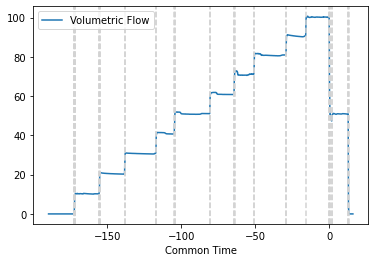

In [7]:
ax = df_Q.plot("Common Time", "Volumetric Flow")
for t in change_times:
    ax.axvline(t, c="lightgray", ls="--")

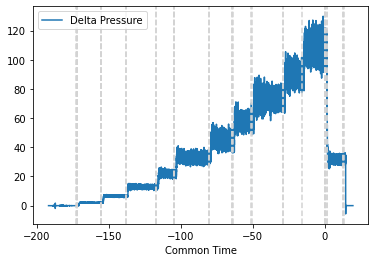

In [8]:
ax = df_DP.plot("Common Time", "Delta Pressure")
for t in change_times:
    ax.axvline(t, c="lightgray", ls="--")

,Common Time,Volumetric Flow
Binned Time,,
-1895,-189.597,0.0
-1894,-189.488,0.0
-1893,-189.378,0.0
-1892,-189.269,0.0
-1891,-189.160,0.0
...,...,...
155,15.583,0.0
156,15.692,0.0
158,15.801,0.0


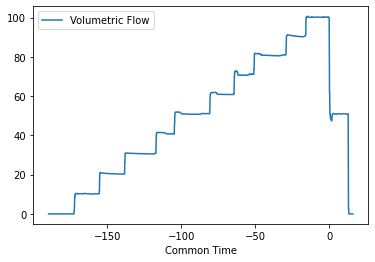

In [9]:
binned_Q = df_Q[["Common Time", "Binned Time", "Volumetric Flow"]].groupby("Binned Time").mean()
binned_Q.plot("Common Time", "Volumetric Flow")
binned_Q

,Common Time,Delta Pressure
Binned Time,,
-1916,-191.628254,-0.002615
-1915,-191.550240,-0.007600
-1914,-191.450040,-0.010050
-1913,-191.351079,-0.006211
-1912,-191.251119,-0.002429
...,...,...
191,19.148815,0.008450
192,19.248000,0.010200
193,19.350010,0.004857


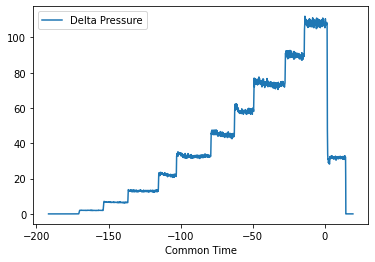

In [10]:
binned_DP = df_DP[["Common Time", "Binned Time", "Delta Pressure"]].groupby("Binned Time").mean()
binned_DP.plot("Common Time", "Delta Pressure")
binned_DP

In [11]:
df = pd.merge(binned_Q, binned_DP, how="inner", on="Binned Time")
df

,Common Time_x,Volumetric Flow,Common Time_y,Delta Pressure
Binned Time,,,,
-1895,-189.597,0.0,-189.547735,-0.005100
-1894,-189.488,0.0,-189.447170,0.002550
-1893,-189.378,0.0,-189.347605,-0.005100
-1892,-189.269,0.0,-189.247225,-0.007650
-1891,-189.160,0.0,-189.147545,-0.002550
...,...,...,...,...
155,15.583,0.0,15.550267,0.011143
156,15.692,0.0,15.654755,0.009250
158,15.801,0.0,15.851452,0.009714


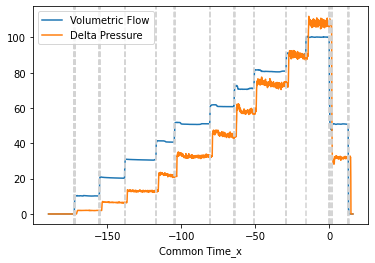

In [29]:
ax = df.plot("Common Time_x", ["Volumetric Flow", "Delta Pressure"])
for t in change_times:
    ax.axvline(t, c="lightgray", ls="--")
ax.figure.savefig(filename_sanity)

In [20]:
since_change = df["Common Time_x"].values[:, np.newaxis] - change_times[np.newaxis, :]
df["Recent Change"] = np.any((-2 <= since_change) & (since_change < 8), axis=1)
since_change[since_change < 0] = np.inf
df["Since Change"] = np.min(since_change, axis=1)
df

,Common Time_x,Volumetric Flow,Common Time_y,Delta Pressure,Recent Change,Since Change
Binned Time,,,,,,
-1895,-189.597,0.0,-189.547735,-0.005100,False,inf
-1894,-189.488,0.0,-189.447170,0.002550,False,inf
-1893,-189.378,0.0,-189.347605,-0.005100,False,inf
-1892,-189.269,0.0,-189.247225,-0.007650,False,inf
-1891,-189.160,0.0,-189.147545,-0.002550,False,inf
...,...,...,...,...,...,...
155,15.583,0.0,15.550267,0.011143,True,2.439
156,15.692,0.0,15.654755,0.009250,True,2.548
158,15.801,0.0,15.851452,0.009714,True,2.657


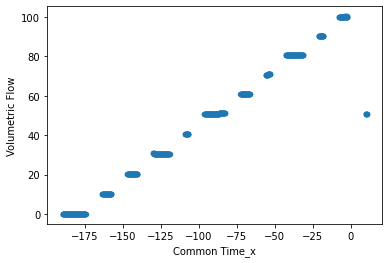

In [14]:
df[~df["Recent Change"]].plot.scatter("Common Time_x", "Volumetric Flow")

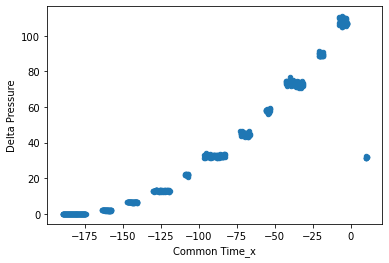

In [15]:
df[~df["Recent Change"]].plot.scatter("Common Time_x", "Delta Pressure")

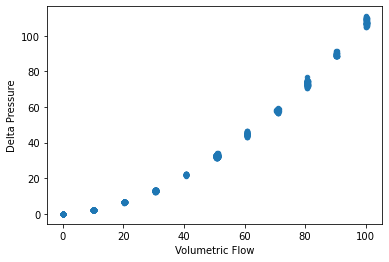

In [16]:
df[~df["Recent Change"]].plot.scatter("Volumetric Flow", "Delta Pressure")

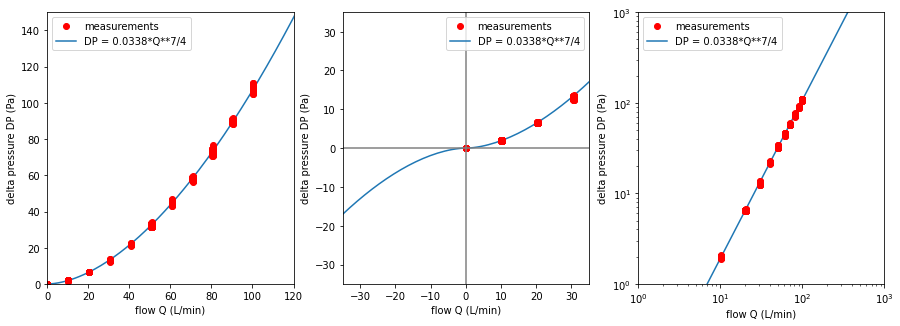

In [17]:
xs = df[~df["Recent Change"]]["Volumetric Flow"].values
ys = df[~df["Recent Change"]]["Delta Pressure"].values

def fit(x, constant):
    return np.sign(x)*(constant * abs(x)**(7.0/4.0))

(fit_constant,), covariance = scipy.optimize.curve_fit(fit, xs, ys)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
curve_xs = np.linspace(-35, 1000, 1000)

for ax in (ax1, ax2, ax3):
    h2, = ax.plot(curve_xs, fit(curve_xs, fit_constant), label="DP = {:.4f}*Q**7/4".format(fit_constant))
    h0, = ax.plot(xs, ys, "o", c="red", label="measurements")
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 150)
    ax.set_xlabel("flow Q (L/min)")
    ax.set_ylabel("delta pressure DP (Pa)")
    ax.legend(handles=[h0, h2])

ax2.axvline(0, c="gray")
ax2.axhline(0, c="gray")
ax2.set_xlim(-35, 35)
ax2.set_ylim(-35, 35)

ax3.set_xlim(1, 1000)
ax3.set_ylim(1, 1000)
ax3.set_yscale("log")
ax3.set_xscale("log")

In [25]:
dfout = df[["Common Time_x", "Since Change", "Recent Change", "Volumetric Flow", "Delta Pressure"]].sort_index()
dfout

,Common Time_x,Since Change,Recent Change,Volumetric Flow,Delta Pressure
Binned Time,,,,,
-1895,-189.597,inf,False,0.0,-0.005100
-1894,-189.488,inf,False,0.0,0.002550
-1893,-189.378,inf,False,0.0,-0.005100
-1892,-189.269,inf,False,0.0,-0.007650
-1891,-189.160,inf,False,0.0,-0.002550
...,...,...,...,...,...
155,15.583,2.439,True,0.0,0.011143
156,15.692,2.548,True,0.0,0.009250
158,15.801,2.657,True,0.0,0.009714


In [26]:
dfout.to_csv(filename_out)